# Imports

In [1]:
import pathlib

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pmdarima as pm

In [28]:
from pmdarima.arima import ndiffs
from pmdarima.metrics import smape
from pmdarima.pipeline import Pipeline
from pmdarima.model_selection import (train_test_split, 
                                      cross_val_score, 
                                      RollingForecastCV)
from pmdarima.preprocessing import (LogEndogTransformer, 
                                    BoxCoxEndogTransformer,
                                    FourierFeaturizer)

# Constants

In [4]:
PROJECT_DIR = pathlib.Path('~/work').expanduser()
DATA_DIR = PROJECT_DIR / 'data'

# Data

In [5]:
data_fb = pd.read_csv(
    filepath_or_buffer=DATA_DIR / 'FB.csv', 
    parse_dates=['Date'], 
    index_col=['Date']
)

In [6]:
data_temp = pd.read_csv(
    filepath_or_buffer=DATA_DIR / 'Mean_Temp_IMD_2017.csv',
    parse_dates=['YEAR'],
    index_col=['YEAR']
)

In [7]:
data_births = pd.read_csv(
    filepath_or_buffer=DATA_DIR / 'daily-total-female-births-CA.csv',
    index_col=['date'],
    parse_dates=['date']
)

# Types of Stationary Behavior in a Time Series

## data_fb

In [8]:
series = data_fb['Close']

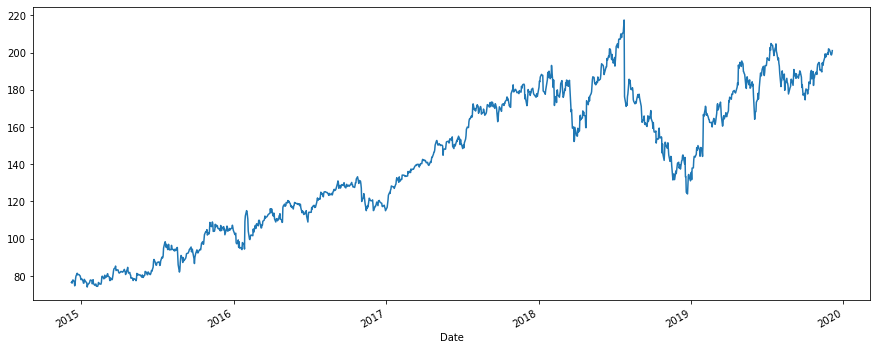

In [9]:
series.plot(figsize=(15, 6))
plt.show()

In [10]:
d = ndiffs(series, alpha=0.05, test='adf')
d

1

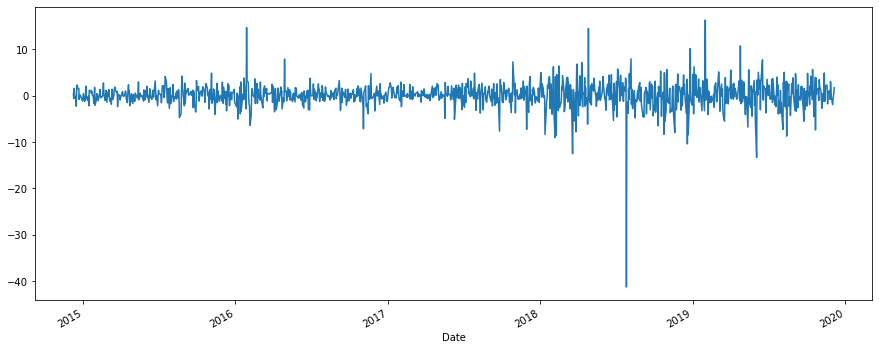

In [11]:
series.diff(d).plot(figsize=(15, 6))
plt.show()

In [12]:
ndiffs(series.diff(d).dropna(), alpha=0.05, test='adf')

0

## data_temp

In [13]:
series = data_temp['ANNUAL_AVG_TEMPRATURE']

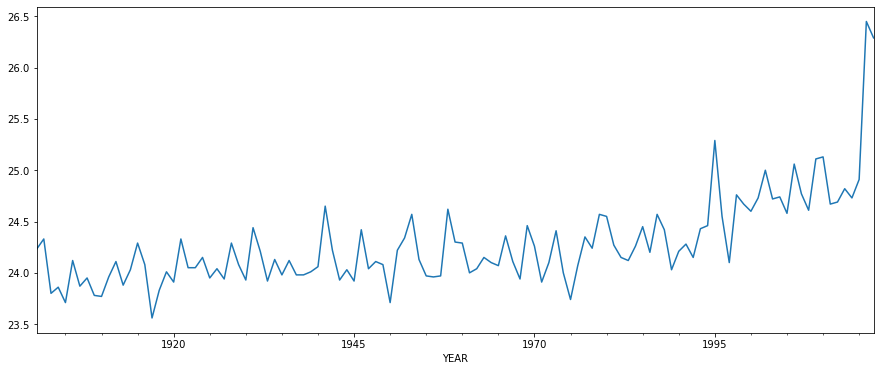

In [14]:
series.plot(figsize=(15, 6))
plt.show()

In [15]:
d = ndiffs(series, alpha=0.05, test='adf')
d

1

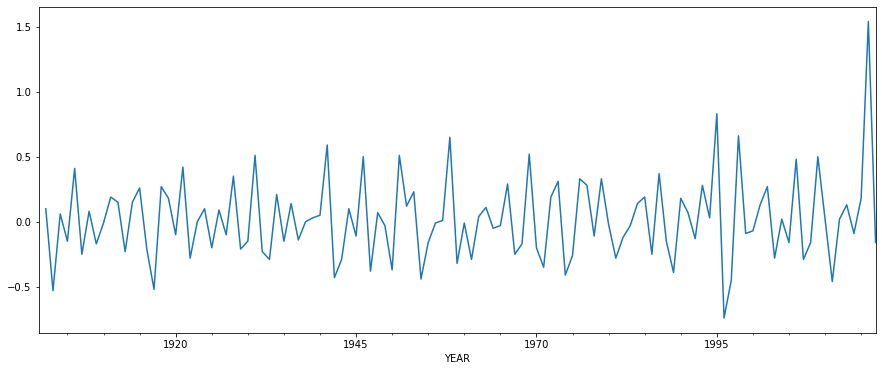

In [16]:
series.diff(d).plot(figsize=(15, 6))
plt.show()

In [17]:
ndiffs(series.diff(d).dropna(), alpha=0.05, test='adf')

0

# AR

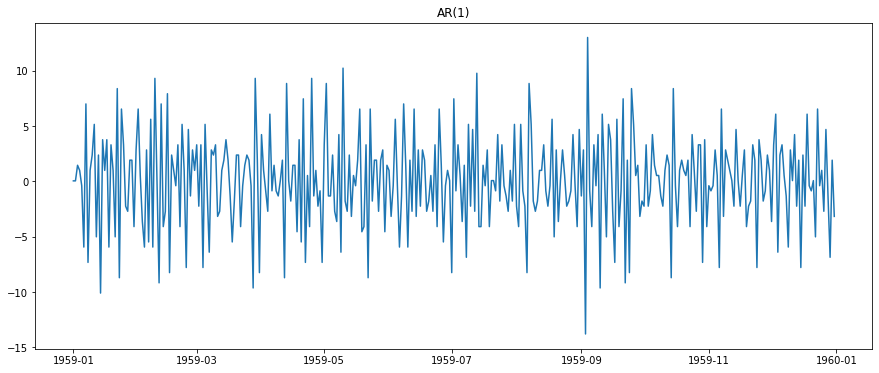

In [18]:
model_ar1 = pm.ARIMA(order=(1, 0, 0))
model_ar1.fit(data_births['births'].diff())

plt.figure(figsize=(15, 6))
plt.plot(data_births.index, model_ar1.predict_in_sample())
plt.title('AR(1)')
plt.show()

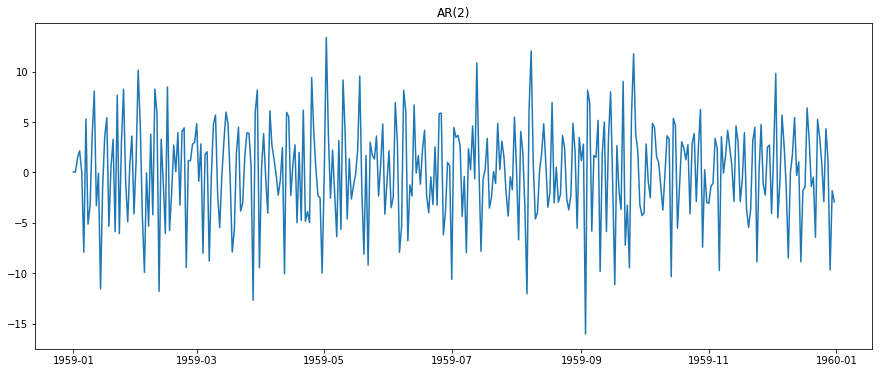

In [19]:
model_ar2 = pm.ARIMA(order=(2, 0, 0))
model_ar2.fit(data_births['births'].diff())

plt.figure(figsize=(15, 6))
plt.plot(data_births.index, model_ar2.predict_in_sample())
plt.title('AR(2)')
plt.show()

# MA

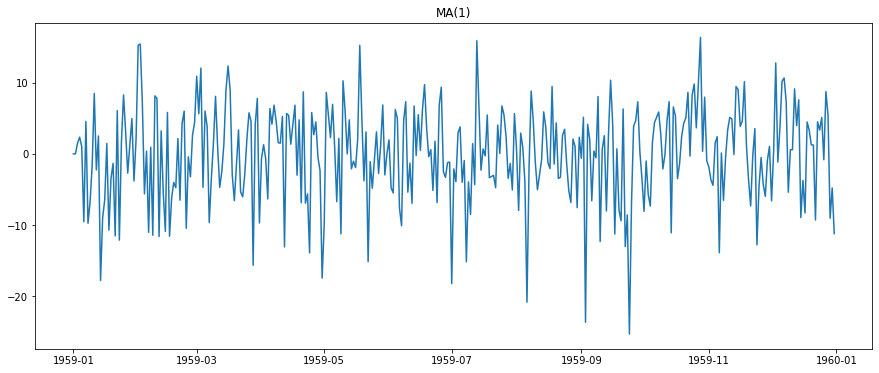

In [20]:
model_ma1 = pm.ARIMA(order=(0, 0, 1))
model_ma1.fit(data_births['births'].diff())

plt.figure(figsize=(15, 6))
plt.plot(data_births.index, model_ma1.predict_in_sample())
plt.title('MA(1)')
plt.show()

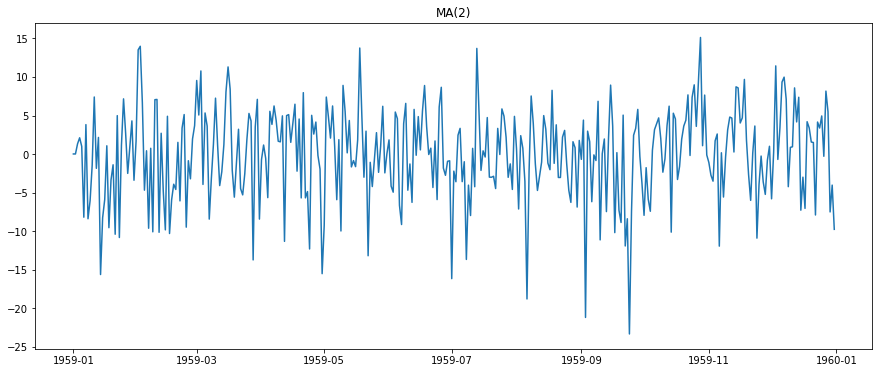

In [21]:
model_ma2 = pm.ARIMA(order=(0, 0, 2))
model_ma2.fit(data_births['births'].diff())

plt.figure(figsize=(15, 6))
plt.plot(data_births.index, model_ma2.predict_in_sample())
plt.title('MA(2)')
plt.show()

# ACF and PACF

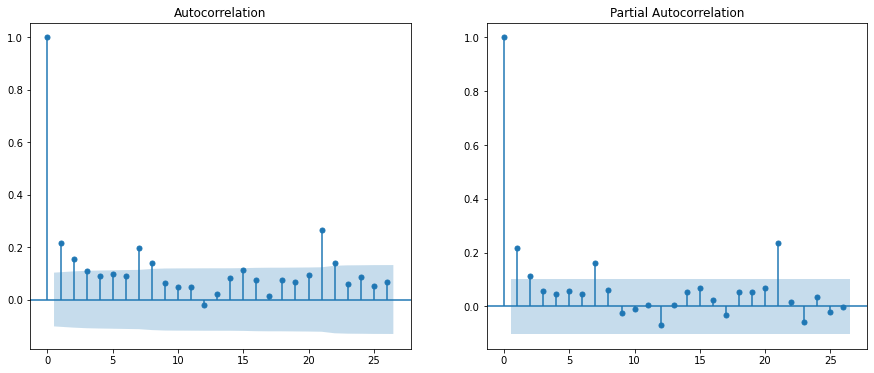

In [22]:
%%capture --no-display
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
pm.plot_acf(data_births['births'], alpha=0.05, ax=ax1, show=False)
pm.plot_pacf(data_births['births'], alpha=0.05, ax=ax2, show=False)
plt.show()

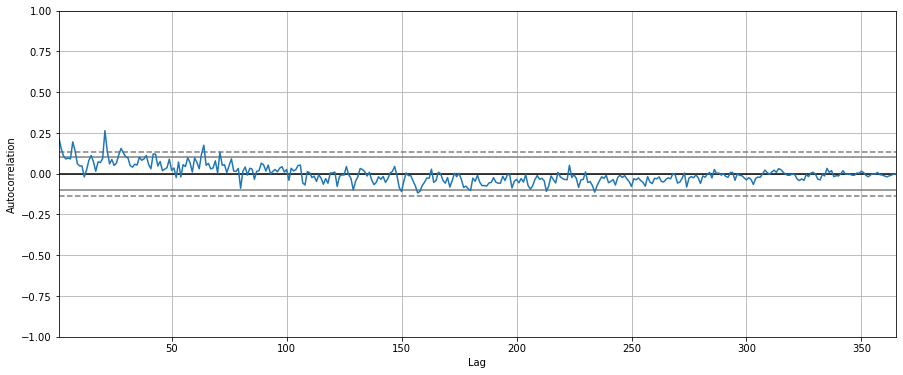

In [23]:
plt.figure(figsize=(15, 6))
pm.autocorr_plot(data_births['births'])

# ARIMA

In [8]:
train, test = pm.model_selection.train_test_split(
    pm.datasets.load_gasoline(as_series=True), 
    test_size=52
)

In [9]:
train.head()

0    6621.0
1    6433.0
2    6582.0
3    7224.0
4    6875.0
dtype: float64

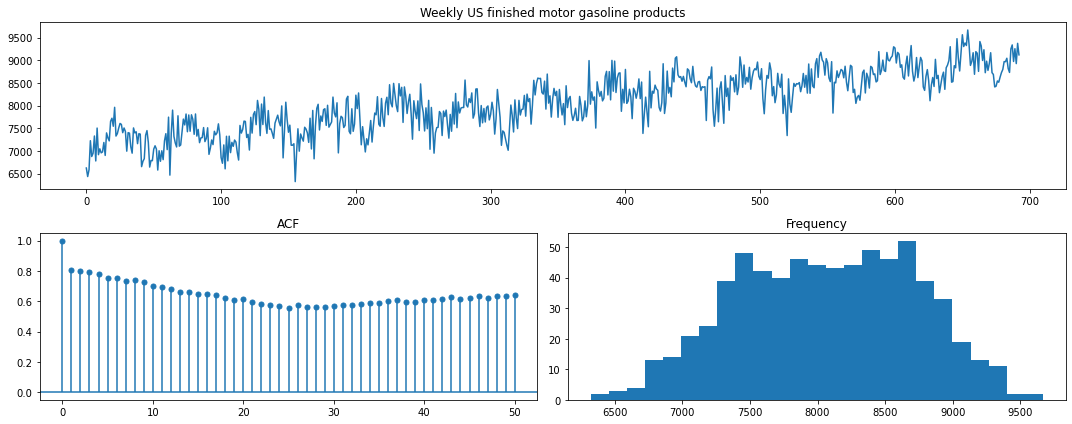

In [10]:
%%capture --no-display
pm.tsdisplay(
    y=train, 
    figsize=(15, 6),
    title="Weekly US finished motor gasoline products"
)

In [11]:
max(pm.arima.ndiffs(train, alpha=0.05, test='kpss'),
    pm.arima.ndiffs(train, alpha=0.05, test='adf'),
    pm.arima.ndiffs(train, alpha=0.05, test='pp'))

1

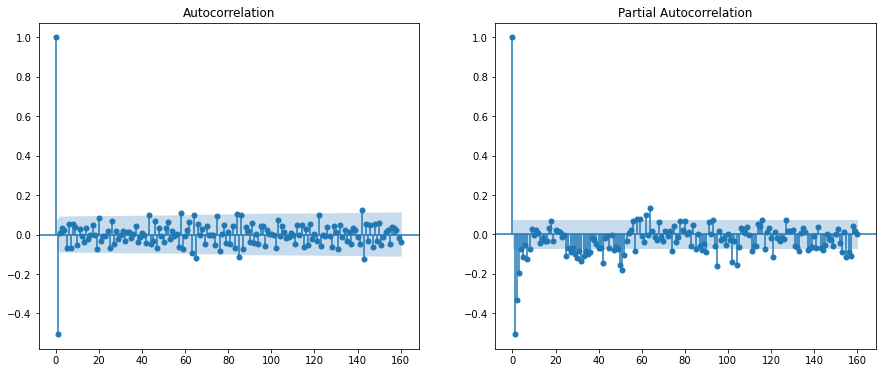

In [12]:
%%capture --no-display
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
pm.plot_acf(train.diff(1).dropna(), alpha=0.05, ax=ax1, show=False, lags=160)
pm.plot_pacf(train.diff(1).dropna(), alpha=0.05, ax=ax2, show=False, lags=160)
plt.show()

In [13]:
pipeline = Pipeline([
    ('endog_transformer', LogEndogTransformer()),
    ('model', pm.AutoARIMA(seasonal=False, 
                           information_criterion='aicc', 
                           suppress_warnings=True, 
                           error_action='ignore', 
                           trace=False))
])

In [14]:
%%time
cv_scores = cross_val_score(
    estimator=pipeline, 
    y=train, 
    scoring='smape', 
    cv=RollingForecastCV(h=52, step=52)
)

CPU times: user 19.9 s, sys: 14.3 s, total: 34.2 s
Wall time: 11.8 s


In [15]:
cv_scores.mean(), cv_scores.std()

(3.7212422352704575, 0.733158784095466)

In [16]:
pipeline.fit(train)

Pipeline(steps=[('endog_transformer', LogEndogTransformer()),
                ('model',
                 AutoARIMA(error_action='ignore', information_criterion='aicc',
                           seasonal=False))])

In [17]:
pipeline.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  693
Model:               SARIMAX(0, 1, 1)   Log Likelihood                1241.148
Date:                Thu, 14 Jan 2021   AIC                          -2478.296
Time:                        11:09:58   BIC                          -2469.217
Sample:                             0   HQIC                         -2474.785
                                - 693                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7408      0.026    -28.321      0.000      -0.792      -0.689
sigma2         0.0016   8.04e-05     20.124      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   1.07   Jarque-Bera (JB):                14.32
Prob(Q):                              0.30   Prob(JB):                         0.00
Heteroskedasticity (H):               0.65   Skew:                            -0.29
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [18]:
forecast, conf_int = pipeline.predict(n_periods=52, return_conf_int=True)

In [19]:
smape(test, forecast)

1.8114509144173614

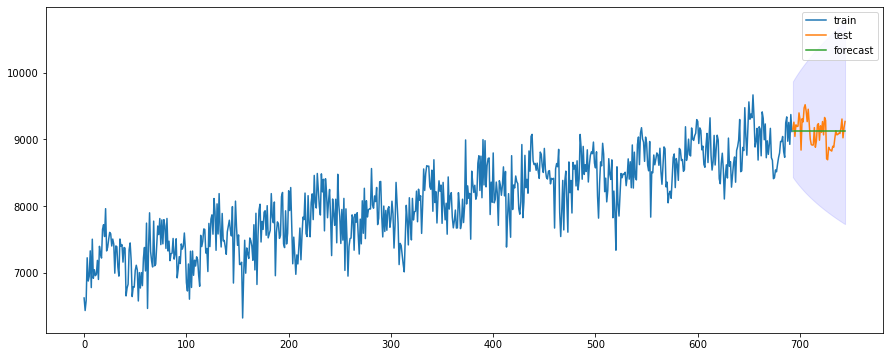

In [20]:
plt.figure(figsize=(15, 6))
plt.plot(train.index, train, label='train')
plt.plot(test.index, test, label='test')
plt.plot(test.index, forecast, label='forecast')
plt.fill_between(x=test.index, 
                 y1=conf_int[:, 0], 
                 y2=conf_int[:, 1],
                 alpha=0.1, color='b')
plt.legend()
plt.show()

# SARIMA

In [8]:
train, test = pm.model_selection.train_test_split(
    pm.datasets.load_gasoline(as_series=True), 
    test_size=52
)

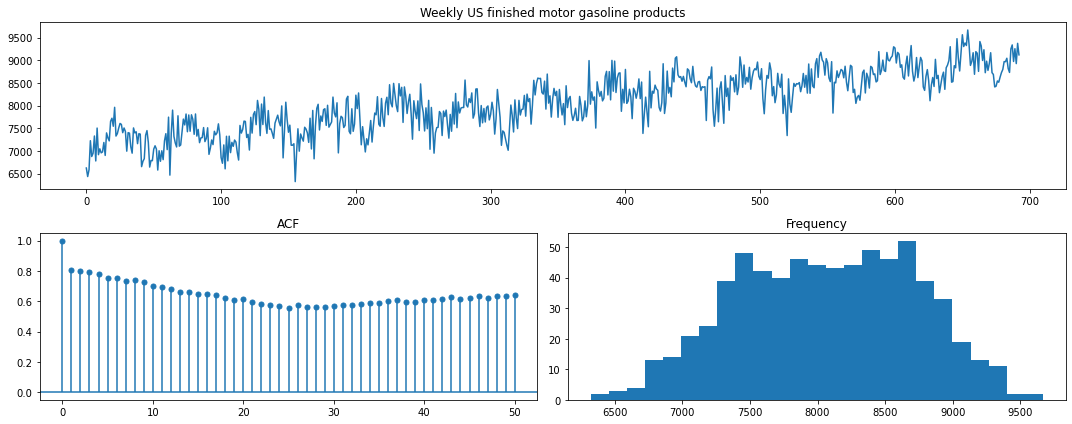

In [9]:
%%capture --no-display
pm.tsdisplay(
    y=train, 
    figsize=(15, 6),
    title="Weekly US finished motor gasoline products"
)

In [10]:
def trend_strength(x, m):
    d = pm.decompose(x, 'additive', m=m)
    return max(0, 1 - np.nanvar(d.random)/np.nanvar(d.random + d.trend))

def seasonality_strength(x, m):
    d = pm.decompose(x, 'additive', m=m)
    return max(0, 1 - np.nanvar(d.random)/np.nanvar(d.random + d.seasonal))

In [11]:
season_df = pd.DataFrame(
    data=[(m, seasonality_strength(train, m)) 
          for m in range(2, 70)],
    columns=['m', 'seasonality_strength']
)

In [12]:
(season_df
 .sort_values('seasonality_strength', ascending=False)
 .head())

,m,seasonality_strength
50,52,0.440353
51,53,0.249668
52,54,0.240746
49,51,0.164934
48,50,0.153400


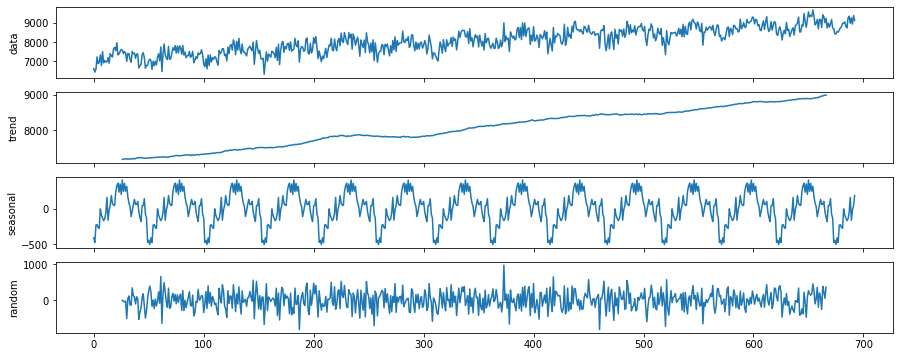

In [13]:
pm.utils.decomposed_plot(
    decomposed_tuple=pm.decompose(train, 'additive', m=52),
    figure_kwargs={'figsize': (15, 6)}
)

In [14]:
max(pm.arima.ndiffs(train, alpha=0.05, test='kpss'),
    pm.arima.ndiffs(train, alpha=0.05, test='adf'),
    pm.arima.ndiffs(train, alpha=0.05, test='pp'))

1

In [15]:
max(pm.arima.nsdiffs(train, m=52, test='ocsb'),
    pm.arima.nsdiffs(train, m=52, test='ch'))

0

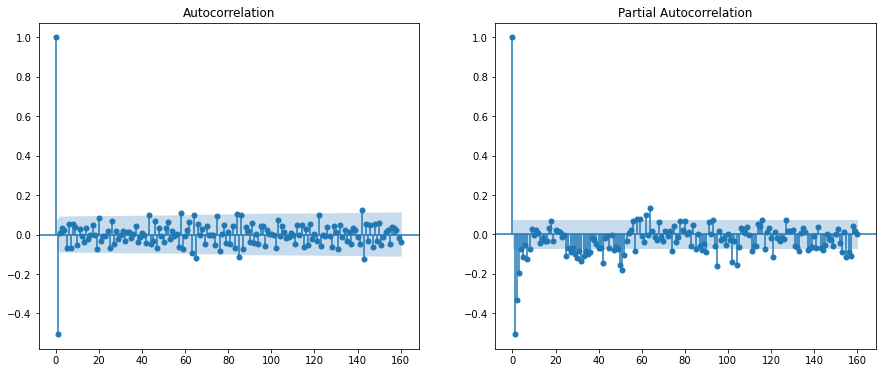

In [16]:
%%capture --no-display
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
pm.plot_acf(train.diff(1).dropna(), alpha=0.05, ax=ax1, show=False, lags=160)
pm.plot_pacf(train.diff(1).dropna(), alpha=0.05, ax=ax2, show=False, lags=160)
plt.show()

In [17]:
pipeline = Pipeline([
    ('endog_transformer', LogEndogTransformer()),
    ('model', pm.AutoARIMA(m=52,
                           method='nm',
                           information_criterion='aicc',
                           suppress_warnings=True, 
                           error_action='ignore', 
                           trace=False))
])

In [31]:
%%time
cv_scores = cross_val_score(
    estimator=pipeline, 
    y=train, 
    scoring='smape', 
    cv=RollingForecastCV(h=52, step=52),
    verbose=2
)

[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
CPU times: user 17min 40s, sys: 10min 31s, total: 28min 12s
Wall time: 7min 4s


In [32]:
cv_scores.mean(), cv_scores.std()

(3.321458831242181, 0.7181952525191018)

In [18]:
pipeline.fit(train)

Pipeline(steps=[('endog_transformer', LogEndogTransformer()),
                ('model',
                 AutoARIMA(error_action='ignore', information_criterion='aicc',
                           m=52, method='nm'))])

In [19]:
pipeline.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  693
Model:             SARIMAX(1, 1, 1)x(1, 0, [1, 2], 52)   Log Likelihood                1266.153
Date:                                 Thu, 14 Jan 2021   AIC                          -2518.305
Time:                                         12:37:38   BIC                          -2486.528
Sample:                                              0   HQIC                         -2506.015
                                                 - 693                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0004      0.000      1.257      0.209      -0.000       0.001
ar.L1         -0.1090      0.046     -2.353      0.019      -0.200      -0.018
ma.L1         -0.7952      0.029    -27.379      0.000      -0.852      -0.738
ar.S.L52       0.3528      0.189      1.869      0.062      -0.017       0.723
ma.S.L52      -0.1011      0.188     -0.539      0.590      -0.469       0.266
ma.S.L104      0.1349      0.065      2.062      0.039       0.007       0.263
sigma2         0.0015    7.4e-05     19.935      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                11.76
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               0.65   Skew:                            -0.25
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [20]:
forecast, conf_int = pipeline.predict(n_periods=52, return_conf_int=True)

In [21]:
smape(test, forecast)

2.2545879369610393

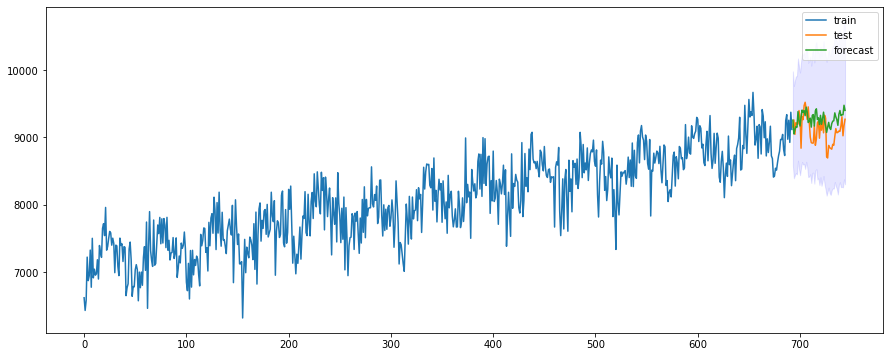

In [22]:
plt.figure(figsize=(15, 6))
plt.plot(train.index, train, label='train')
plt.plot(test.index, test, label='test')
plt.plot(test.index, forecast, label='forecast')
plt.fill_between(x=test.index, 
                 y1=conf_int[:, 0], 
                 y2=conf_int[:, 1],
                 alpha=0.1, color='b')
plt.legend()
plt.show()

# SARIMAX

In [29]:
train, test = pm.model_selection.train_test_split(
    pm.datasets.load_gasoline(as_series=True), 
    test_size=52
)

In [30]:
train.head()

0    6621.0
1    6433.0
2    6582.0
3    7224.0
4    6875.0
dtype: float64

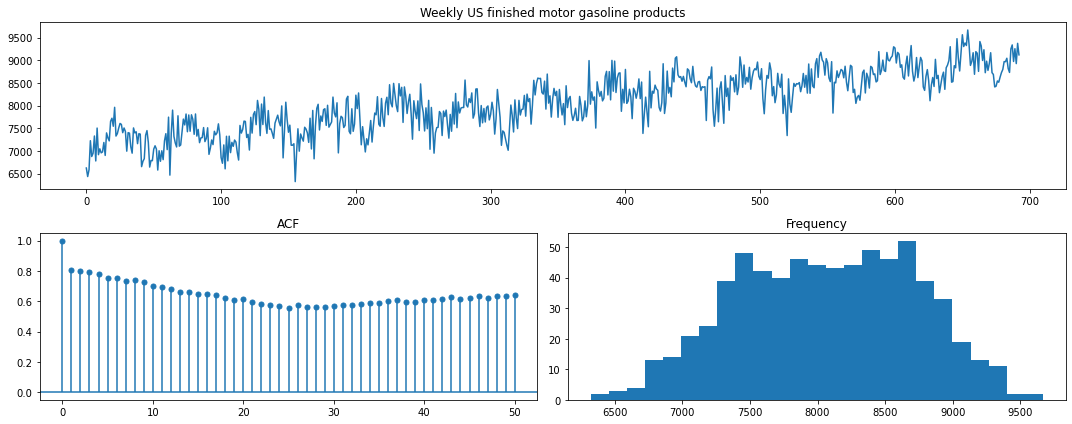

In [31]:
%%capture --no-display
pm.tsdisplay(
    y=train, 
    figsize=(15, 6),
    title="Weekly US finished motor gasoline products"
)

In [32]:
max(pm.arima.ndiffs(train, alpha=0.05, test='kpss'),
    pm.arima.ndiffs(train, alpha=0.05, test='adf'),
    pm.arima.ndiffs(train, alpha=0.05, test='pp'))

1

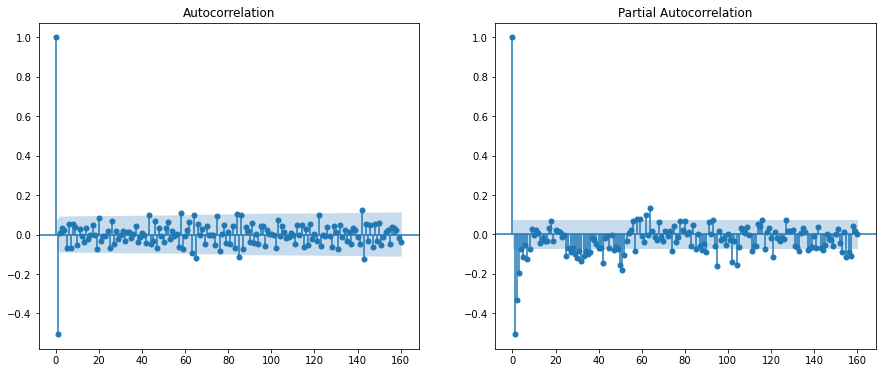

In [33]:
%%capture --no-display
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
pm.plot_acf(train.diff(1).dropna(), alpha=0.05, ax=ax1, show=False, lags=160)
pm.plot_pacf(train.diff(1).dropna(), alpha=0.05, ax=ax2, show=False, lags=160)
plt.show()

In [115]:
pipeline = Pipeline([
    ('fourier_featurizer', FourierFeaturizer(m=365.25 / 7, k=3)),
    ('model', pm.AutoARIMA(seasonal=False, 
                           information_criterion='aicc', 
                           suppress_warnings=True, 
                           error_action='ignore', 
                           trace=False))
])

In [116]:
%%time
cv_scores = cross_val_score(
    estimator=pipeline, 
    y=train, 
    scoring='smape', 
    cv=RollingForecastCV(h=52, step=52),
    verbose=2
)

[CV] fold=0 ..........................................................
[CV] fold=1 ..........................................................
[CV] fold=2 ..........................................................
[CV] fold=3 ..........................................................
[CV] fold=4 ..........................................................
[CV] fold=5 ..........................................................
[CV] fold=6 ..........................................................
[CV] fold=7 ..........................................................
CPU times: user 1min 15s, sys: 56.7 s, total: 2min 11s
Wall time: 41.8 s


In [117]:
cv_scores.mean(), cv_scores.std()

(2.797386952621461, 0.4437518401407087)

In [118]:
pipeline.fit(train)

Pipeline(steps=[('fourier_featurizer',
                 FourierFeaturizer(k=3, m=52.17857142857143)),
                ('model',
                 AutoARIMA(error_action='ignore', information_criterion='aicc',
                           seasonal=False))])

In [119]:
pipeline.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  693
Model:               SARIMAX(5, 1, 1)   Log Likelihood               -4874.334
Date:                Thu, 14 Jan 2021   AIC                           9776.667
Time:                        14:13:35   BIC                           9840.221
Sample:                             0   HQIC                          9801.248
                                - 693                                         
Covariance Type:                  opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept         4.0185      0.704      5.708      0.000       2.639       5.398
FOURIER_S52-0     7.0203     12.253      0.573      0.567     -16.995      31.035
FOURIER_C52-0  -278.6562     12.049    -23.126      0.000    -302.273    -255.040
FOURIER_S52-1   -40.7833     11.834     -3.446      0.001     -63.978     -17.588
FOURIER_C52-1   -19.0636     11.854     -1.608      0.108     -42.297       4.170
FOURIER_S52-2    29.4893     13.063      2.257      0.024       3.886      55.092
FOURIER_C52-2   -97.3432     12.355     -7.879      0.000    -121.558     -73.128
ar.L1            -0.0964      0.040     -2.414      0.016      -0.175      -0.018
ar.L2            -0.0653      0.039     -1.661      0.097      -0.142       0.012
ar.L3            -0.0358      0.041     -0.866      0.387      -0.117       0.045
ar.L4            -0.0630      0.040     -1.561      0.118      -0.142       0.016
ar.L5            -0.1219      0.040     -3.075      0.002      -0.200      -0.044
ma.L1            -0.9436      0.016    -60.133      0.000      -0.974      -0.913
sigma2         7.573e+04   4018.429     18.845      0.000    6.79e+04    8.36e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 3.65
Prob(Q):                              0.88   Prob(JB):                         0.16
Heteroskedasticity (H):               0.82   Skew:                            -0.17
Prob(H) (two-sided):                  0.13   Kurtosis:                         3.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [120]:
forecast, conf_int = pipeline.predict(n_periods=52, return_conf_int=True)

In [121]:
smape(test, forecast)

1.2971314095974336

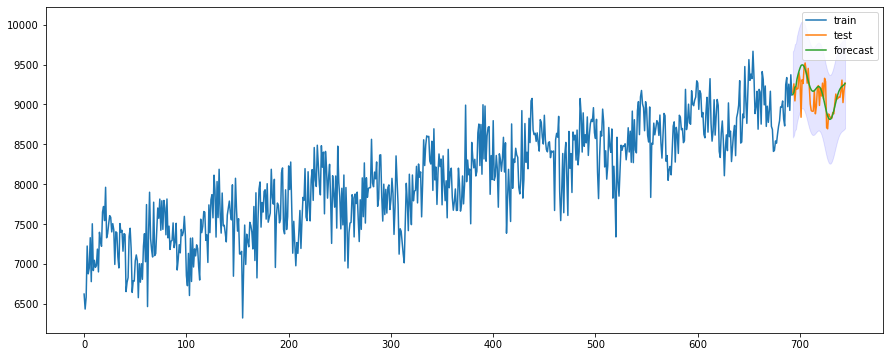

In [122]:
plt.figure(figsize=(15, 6))
plt.plot(train.index, train, label='train')
plt.plot(test.index, test, label='test')
plt.plot(test.index, forecast, label='forecast')
plt.fill_between(x=test.index, 
                 y1=conf_int[:, 0], 
                 y2=conf_int[:, 1],
                 alpha=0.1, color='b')
plt.legend()
plt.show()